
[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\Dirck\AppData\Local\Temp\ipykernel_31756\584514150.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2015-01-01', end='2023-01-01')
[*********************100%***********************]  1 of 1 completed
C:\Users\Dirck\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0161 - val_loss: 0.0051
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 9.3206e-04 - val_loss: 0.0027
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 9.4841e-04 - val_loss: 0.0023
Epoch 8/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 9.5378e-04 - val_loss: 0.0014
Epoch 9/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 7.5239e-04 - val_loss: 0.0029
Epoch 10/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 6.4426e-04 - val_loss: 0.0039
Epoch 11/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 7.8466e-04 - val_loss: 0.0013
Epoch 12/25
48/48 ━━━━━━━━━━━━━━━━━━━━

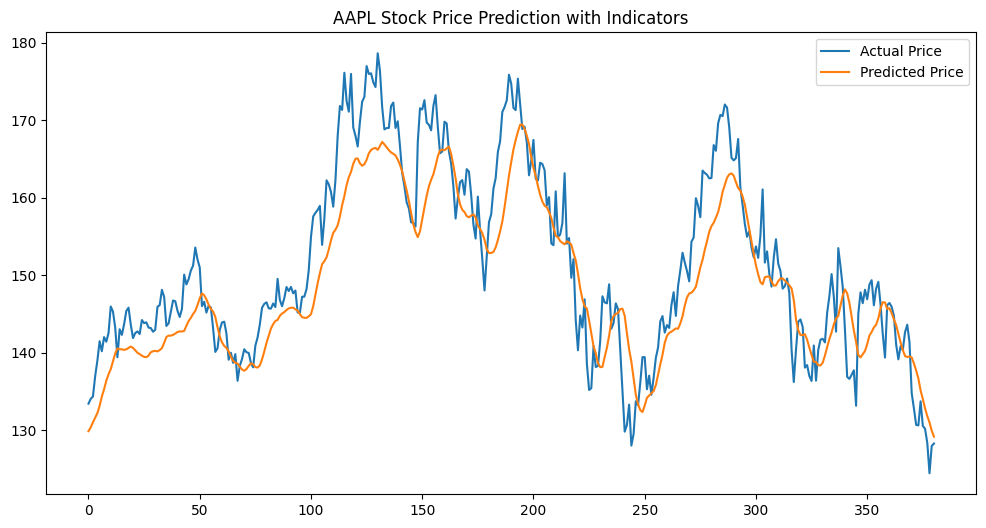

In [4]:
!pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Fetch data
ticker = 'AAPL'
df = yf.download(ticker, start='2015-01-01', end='2023-01-01')
df['MA50'] = df['Close'].rolling(window=50).mean()
df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(14).mean()))
df = df.dropna()

# Feature engineering
features = df[['Close', 'MA50', 'RSI']].values
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Time series preprocessing
def create_sequences(data, step=60):
    X, y = [], []
    for i in range(step, len(data)):
        X.append(data[i-step:i])
        y.append(data[i, 0])  # Predict closing price
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)

# Predict
predicted = model.predict(X_test)
predicted_price = scaler.inverse_transform(np.hstack((predicted, np.zeros((len(predicted), 2)))))[:, 0]
actual_price = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((len(y_test), 2)))))[:, 0]

# Plot results
plt.figure(figsize=(12,6))
plt.plot(actual_price, label='Actual Price')
plt.plot(predicted_price, label='Predicted Price')
plt.title(f'{ticker} Stock Price Prediction with Indicators')
plt.legend()
plt.show()


In [5]:
# Compare predicted prices to generate signals
signals = []
for actual, predicted in zip(actual_price, predicted_price):
    if predicted > actual:
        signals.append('Buy')
    elif predicted < actual:
        signals.append('Sell')
    else:
        signals.append('Hold')

# Preview last few signals alongside actual/predicted
for i in range(-10, 0):
    print(f"Day {i}: Actual={actual_price[i]:.2f}, Predicted={predicted_price[i]:.2f}, Signal={signals[i]}")


Day -10: Actual=132.79, Predicted=138.61, Signal=Buy
Day -9: Actual=130.68, Predicted=137.70, Signal=Buy
Day -8: Actual=130.61, Predicted=136.67, Signal=Buy
Day -7: Actual=133.72, Predicted=135.12, Signal=Buy
Day -6: Actual=130.54, Predicted=134.01, Signal=Buy
Day -5: Actual=130.17, Predicted=132.82, Signal=Buy
Day -4: Actual=128.37, Predicted=131.81, Signal=Buy
Day -3: Actual=124.43, Predicted=130.99, Signal=Buy
Day -2: Actual=127.95, Predicted=129.91, Signal=Buy
Day -1: Actual=128.27, Predicted=129.16, Signal=Buy


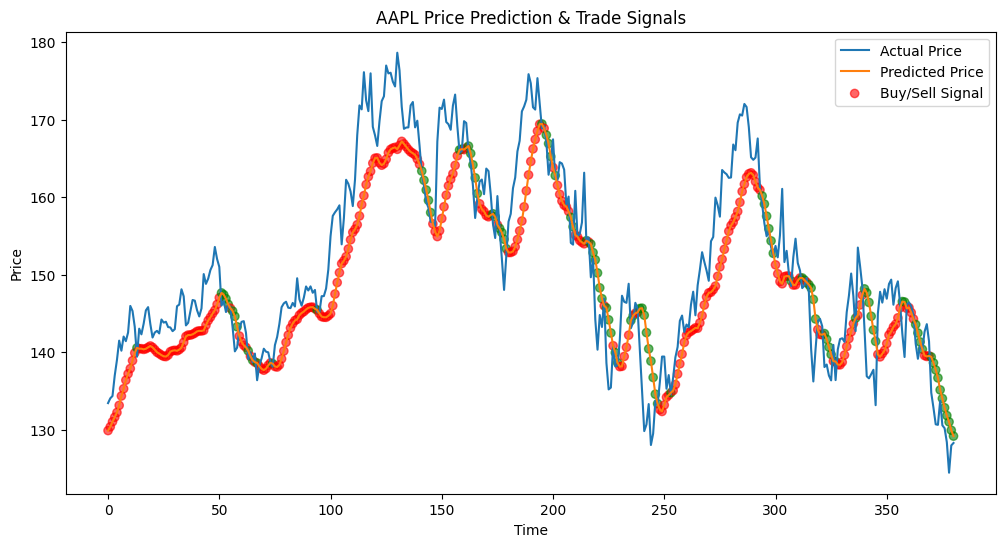

In [6]:
plt.figure(figsize=(12,6))
plt.plot(actual_price, label='Actual Price')
plt.plot(predicted_price, label='Predicted Price')
plt.scatter(
    range(len(signals)),
    predicted_price,
    c=['green' if s == 'Buy' else 'red' if s == 'Sell' else 'gray' for s in signals],
    label='Buy/Sell Signal',
    alpha=0.6
)
plt.title(f'{ticker} Price Prediction & Trade Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
